#APTOS 2019 Blindness Detection
#Detect diabetic retinopathy to stop blindness before it's too late

![image.png](https://th.bing.com/th/id/R.e6d60a41e4808c2da29f42c391e01fa3?rik=w3LWu2eY%2bwT%2fsg&riu=http%3a%2f%2fcceyemd.com%2fwp-content%2fuploads%2f2020%2f09%2f5_stages.png&ehk=%2bPM6xmk8fZX0hLZYLLXbzBy0mO8R1zXB0Kp3YdNpQrU%3d&risl=&pid=ImgRaw&r=0)

In this synchronous Kernels-only competition, you'll build a machine learning model to speed up disease detection. You’ll work with thousands of images collected in rural areas to help identify diabetic retinopathy automatically. If successful, you will not only help to prevent lifelong blindness, but these models may be used to detect other sorts of diseases in the future, like glaucoma and macular degeneration.

In this notebook, I will be using basic deep learning and transfer learning (ResNet50) to create a baseline.

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marinareda","key":"5b0c8dea157dc44264fc005991f565bb"}'}

In [3]:
from os import mkdir
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/


In [5]:
! chmod 600 ~/.kaggle/kaggle.json


In [6]:
! kaggle datasets list

ref                                                               title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/global-youtube-statistics-2023                   Global YouTube Statistics 2023                      60KB  2023-07-28 15:36:38           9360        313  1.0              
arjunajn/netflix-watch-log                                        Netflix Watch Log                                  295KB  2023-08-22 08:23:45            585         27  1.0              
vincentcornlius/sales-orders                                      sales orders                                         5MB  2023-08-24 14:04:11            706         23  0.8235294        
kapturovalexander/gold-and-silver-prices-2013-2023     

In [7]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [01:39<00:00, 144MB/s]
100% 9.51G/9.51G [01:39<00:00, 103MB/s]


In [8]:
! unzip aptos2019-blindness-detection.zip


Streaming output truncated to the last 5000 lines.
  inflating: test_images/512beaada8f0.png  
  inflating: test_images/51323e9d2070.png  
  inflating: test_images/515675001b9e.png  
  inflating: test_images/515877da2def.png  
  inflating: test_images/5168ddccea88.png  
  inflating: test_images/5172c056a687.png  
  inflating: test_images/5177461f5339.png  
  inflating: test_images/51910bcb980d.png  
  inflating: test_images/51a3e9b6a1c0.png  
  inflating: test_images/51bbd82feec8.png  
  inflating: test_images/51de5fb8eccd.png  
  inflating: test_images/51e88694c81f.png  
  inflating: test_images/51f0bf8f1544.png  
  inflating: test_images/51f57fb32840.png  
  inflating: test_images/51fa42dc1415.png  
  inflating: test_images/5276ab33b7b0.png  
  inflating: test_images/52a353760f72.png  
  inflating: test_images/531937254e73.png  
  inflating: test_images/5325b1c22c61.png  
  inflating: test_images/53959e0a750b.png  
  inflating: test_images/53be22c72713.png  
  inflating: test_images/

In [30]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
import tensorflow as tf
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(0)
seed_everything()

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [31]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [32]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


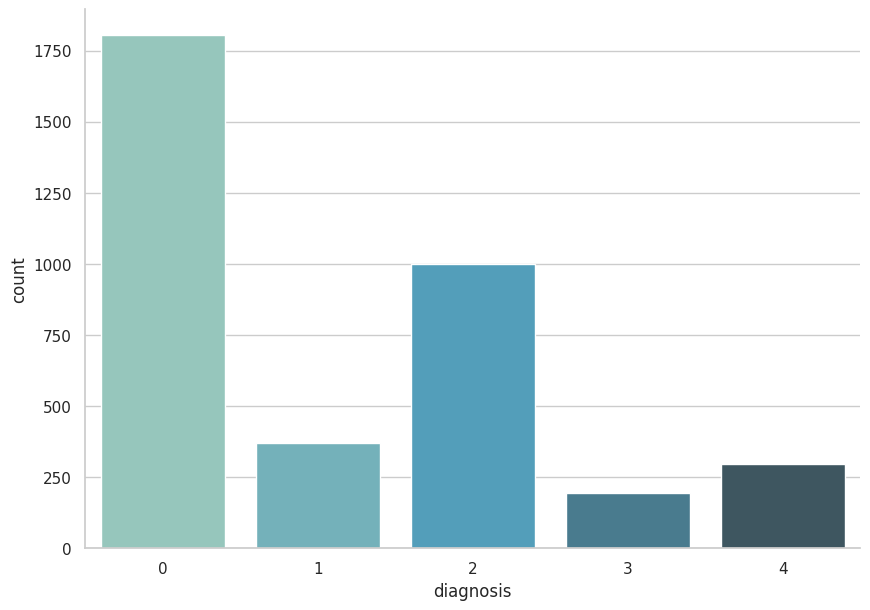

In [33]:
f, ax = plt.subplots(figsize=(10, 7))
ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")
sns.despine()
plt.show()

- 0 - No DR
- 1 - Mild
- 2 - Moderate
- 3 - Severe
- 4 - Proliferative DR

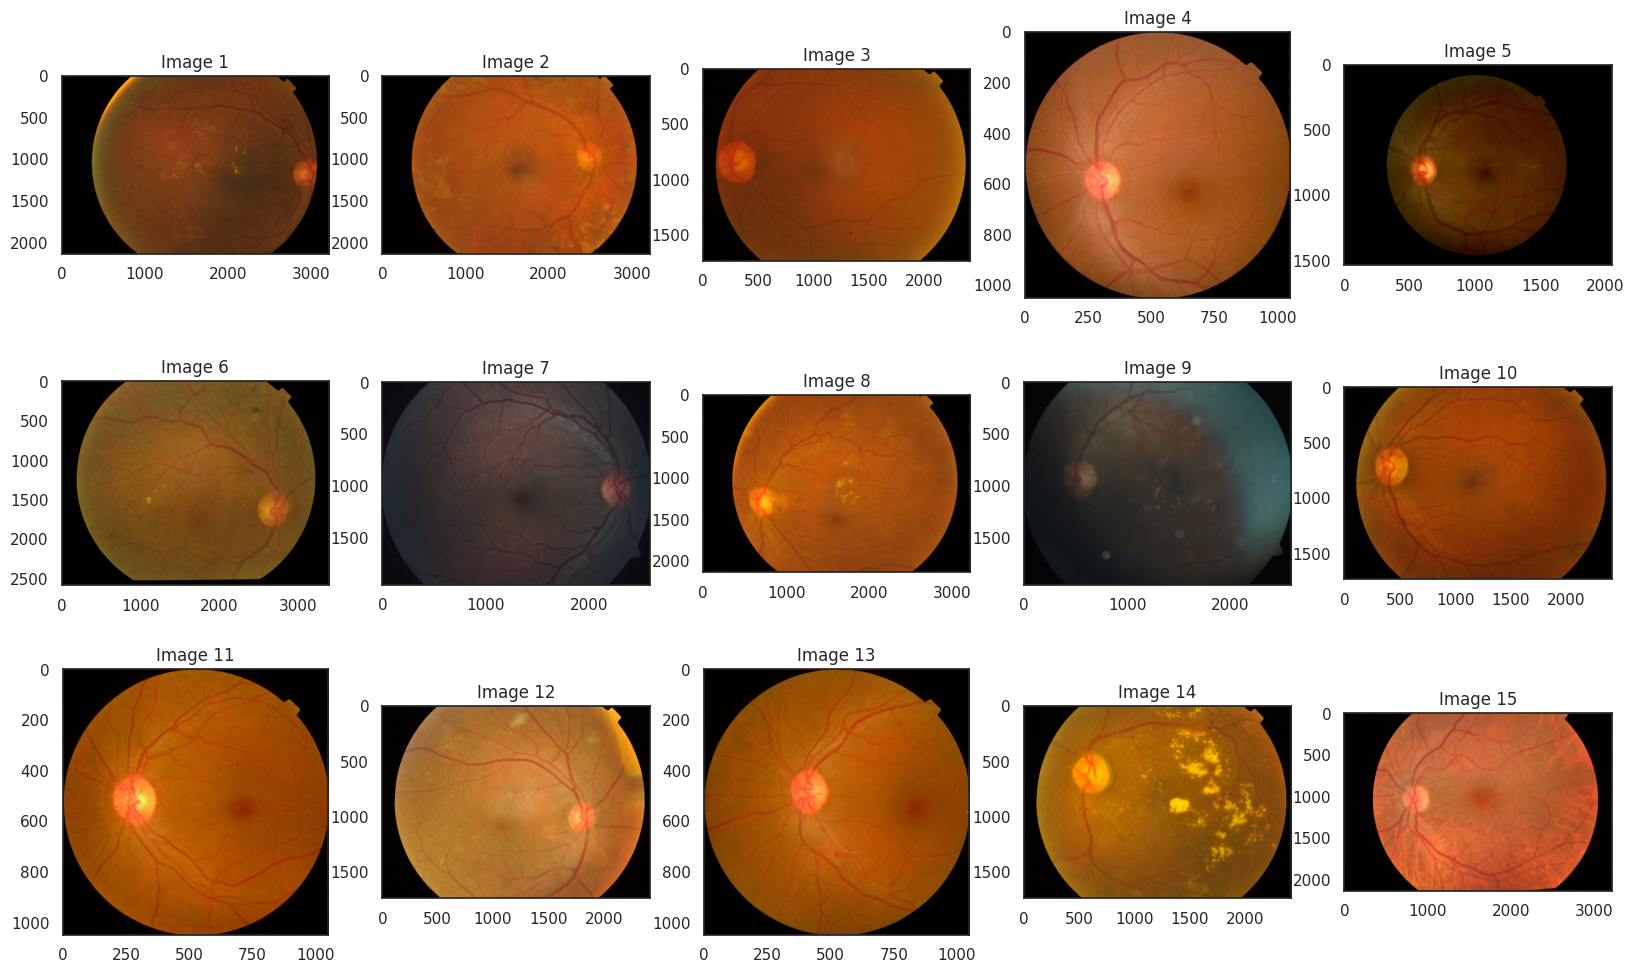

In [36]:
sns.set_style("white")
count = 1
plt.figure(figsize=[20, 20])
for img_name in train['id_code'][:15]:
    img_path = "/content/train_images/%s.png" % img_name
    img = cv2.imread(img_path)

    # Check if the image is loaded successfully
    if img is None:
        print(f"Image not loaded: {img_path}")
        continue

    img = img[..., [2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1

plt.show()


In [14]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 20
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 512
WIDTH = 512
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [15]:
# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [16]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory = "/content/test_images",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [18]:

# Add '.png' extension to id_code
train['id_code'] = train['id_code'].apply(lambda x: x + ".png")
test['id_code'] = test['id_code'].apply(lambda x: x + ".png")

# Convert the labels to string
train['diagnosis'] = train['diagnosis'].astype('str')

In [19]:
# Get the ResNet50 base model
base_model = ResNet50(include_top=False, pooling='avg')

# Make the base model untrainable
base_model.trainable = False

# Define the model
model = Sequential([
    base_model,
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


In [20]:
# Define the callbacks
callbacks = [EarlyStopping(patience=3, restore_best_weights=True),
             ModelCheckpoint(filepath='model.h5', save_best_only=True)]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n//train_generator.batch_size,
    validation_data = valid_generator,
    validation_steps = valid_generator.n//valid_generator.batch_size,
    epochs = 10,
    callbacks=callbacks)

Epoch 1/10
366/366 [==============================] - 503s 1s/step - loss: 1.3897 - accuracy: 0.4613 - val_loss: 1.4839 - val_accuracy: 0.3063
Epoch 2/10
366/366 [==============================] - 450s 1s/step - loss: 1.3478 - accuracy: 0.4808 - val_loss: 1.7934 - val_accuracy: 0.3036
Epoch 3/10
366/366 [==============================] - 484s 1s/step - loss: 1.3341 - accuracy: 0.5096 - val_loss: 1.3965 - val_accuracy: 0.4602
Epoch 4/10
366/366 [==============================] - 485s 1s/step - loss: 1.2971 - accuracy: 0.5216 - val_loss: 1.3250 - val_accuracy: 0.4602
Epoch 5/10
366/366 [==============================] - 439s 1s/step - loss: 1.2662 - accuracy: 0.5161 - val_loss: 1.4165 - val_accuracy: 0.3777
Epoch 6/10
366/366 [==============================] - 436s 1s/step - loss: 1.2503 - accuracy: 0.5418 - val_loss: 1.5449 - val_accuracy: 0.4670
Epoch 7/10
366/366 [==============================] - 490s 1s/step - loss: 1.2504 - accuracy: 0.5483 - val_loss: 1.2483 - val_accuracy: 0.4615

In [21]:
loss, accuracy = model.evaluate(valid_generator)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

92/92 [==============================] - 89s 966ms/step - loss: 1.1077 - accuracy: 0.6530
Loss: 1.1077245473861694
Accuracy: 0.6530054807662964


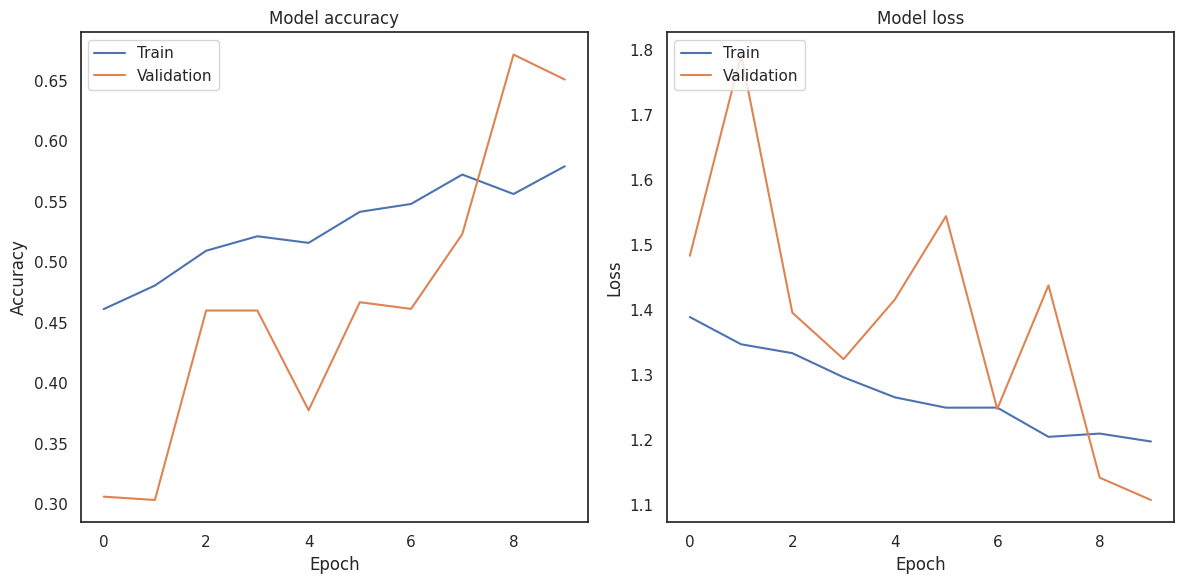

In [22]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 25ms/step


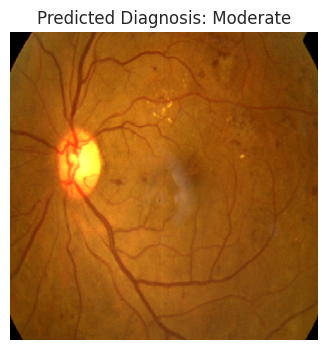

In [45]:
# ------------------------- CHECKER PART -------------------------

# Get a batch of images from the test generator
test_images_batch = next(test_generator)
# Picking the first image from the batch for demonstration
pic = test_images_batch[0]

# Predict the class of this image
Ipic = np.expand_dims(pic, axis=0)
IFpic = model.predict(Ipic)  # Using the model you've trained
predicted_class = np.argmax(IFpic)

# Convert predicted class to its respective category name
diagnosis_map = {
    0: 'No DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferative DR'
}
predicted_diagnosis = diagnosis_map[predicted_class]

# Display the chosen image with its predicted class
plt.figure(figsize=(4, 4))
plt.imshow(pic)
plt.title(f"Predicted Diagnosis: {predicted_diagnosis}")
plt.axis('off')  # Turn off the axis numbers and ticks
plt.show()

# --------------------------------------------------------------



1/1 [==============================] - 0s 25ms/step


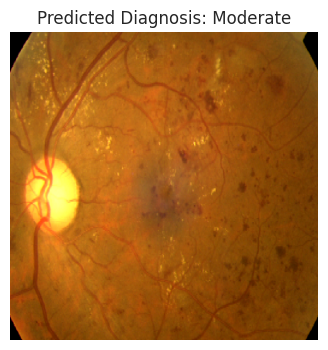

In [48]:
# ------------------------- CHECKER PART -------------------------

# Get a batch of images from the test generator
test_images_batch = next(test_generator)
# Picking the first image from the batch for demonstration
pic = test_images_batch[0]

# Predict the class of this image
Ipic = np.expand_dims(pic, axis=0)
IFpic = model.predict(Ipic)  # Using the model you've trained
predicted_class = np.argmax(IFpic)

# Convert predicted class to its respective category name
diagnosis_map = {
    0: 'No DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferative DR'
}
predicted_diagnosis = diagnosis_map[predicted_class]

# Display the chosen image with its predicted class
plt.figure(figsize=(4, 4))
plt.imshow(pic)
plt.title(f"Predicted Diagnosis: {predicted_diagnosis}")
plt.axis('off')  # Turn off the axis numbers and ticks
plt.show()

# --------------------------------------------------------------



1/1 [==============================] - 0s 24ms/step


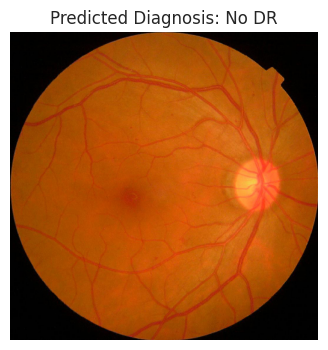

In [47]:
# ------------------------- CHECKER PART -------------------------

# Get a batch of images from the test generator
test_images_batch = next(test_generator)
# Picking the first image from the batch for demonstration
pic = test_images_batch[0]

# Predict the class of this image
Ipic = np.expand_dims(pic, axis=0)
IFpic = model.predict(Ipic)  # Using the model you've trained
predicted_class = np.argmax(IFpic)

# Convert predicted class to its respective category name
diagnosis_map = {
    0: 'No DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferative DR'
}
predicted_diagnosis = diagnosis_map[predicted_class]

# Display the chosen image with its predicted class
plt.figure(figsize=(4, 4))
plt.imshow(pic)
plt.title(f"Predicted Diagnosis: {predicted_diagnosis}")
plt.axis('off')  # Turn off the axis numbers and ticks
plt.show()

# --------------------------------------------------------------



1/1 [==============================] - 0s 36ms/step


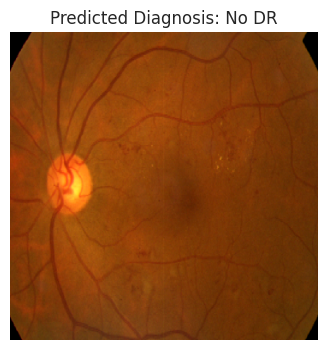

In [79]:
# ------------------------- CHECKER PART -------------------------

# Get a batch of images from the test generator
test_images_batch = next(test_generator)
# Picking the first image from the batch for demonstration
pic = test_images_batch[0]

# Predict the class of this image
Ipic = np.expand_dims(pic, axis=0)
IFpic = model.predict(Ipic)  # Using the model you've trained
predicted_class = np.argmax(IFpic)

# Convert predicted class to its respective category name
diagnosis_map = {
    0: 'No DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferative DR'
}
predicted_diagnosis = diagnosis_map[predicted_class]

# Display the chosen image with its predicted class
plt.figure(figsize=(4, 4))
plt.imshow(pic)
plt.title(f"Predicted Diagnosis: {predicted_diagnosis}")
plt.axis('off')  # Turn off the axis numbers and ticks
plt.show()

# --------------------------------------------------------------

